In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [43]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        X_temp = tas_array.reshape(shape[0]*shape[1], shape[2], shape[3])
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)) .reshape(shape[0]*shape[1], shape[2],shape[3])

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
    return X, y

import numpy as np
from scipy.signal import convolve2d

def mean_convolution(Y, w=3, boundary='symm'):
    # Create a 2D window of ones with size (w, w)
    window = np.ones((w, w)) / (w * w)
    
    # Apply convolution along lat and lon dimensions
    Y_convolve = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        Y_convolve[i] = convolve2d(Y[i], window, mode='same', boundary=boundary)

    return Y_convolve

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [14]:
X, Y = load_data_models(['CanESM5'], var='tas', n_sample=1000, path='../data/', coarse=1)

((1000, 72, 144), (1000, 72, 144))

In [60]:
B = 10
windows = [2, 3, 6, 8, 12]
scores = {w:[] for w in windows}
for b in tqdm(range(B)):
    X, Y = load_data_models(['CanESM5'], var='tas', n_sample=1000, path='../data/', coarse=1)
    shape = Y.shape
    Y_reshaped = Y.reshape(shape[0], shape[1]*shape[2])
    for w in windows:
        Y_pred = mean_convolution(X, w=w, boundary='fill')
        Y_pred_reshaped = Y_pred.reshape(shape[0], shape[1]*shape[2])
        scores[w].append(r2_score(Y_reshaped, Y_pred_reshaped))

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


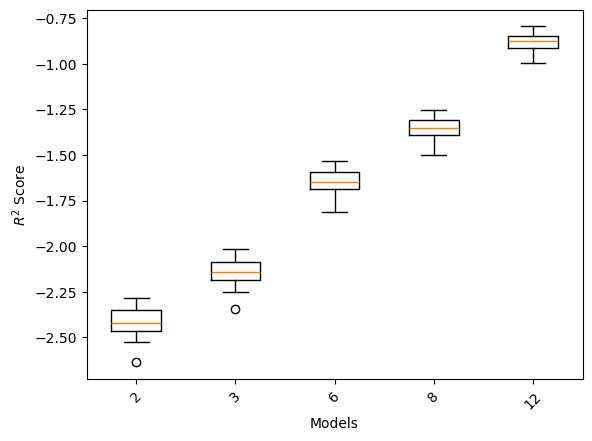

In [61]:
plt.boxplot([scores[w] for w in windows])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(windows) + 1), windows, rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_concolution_coarse.pdf", format="pdf", bbox_inches="tight")

plt.show()